# Data 200
### Applied Statistical Analysis (Week 1)
**Multiple Linear Regression, Diagnostics and Remedial Measures** - Aayush Regmi

## Importing necessary Libraries

In [53]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm
from statsmodels.stats.stattools import durbin_watson
from statsmodels.stats.diagnostic import het_breuschpagan
from scipy import stats
import seaborn as sns

## Loading Dataset

In [54]:
data = pd.read_csv('https://www.statlearning.com/s/Advertising.csv', index_col=0)
data.head()

,TV,radio,newspaper,sales
1,230.1,37.8,69.2,22.1
2,44.5,39.3,45.1,10.4
3,17.2,45.9,69.3,9.3
4,151.5,41.3,58.5,18.5
5,180.8,10.8,58.4,12.9


<Axes: >

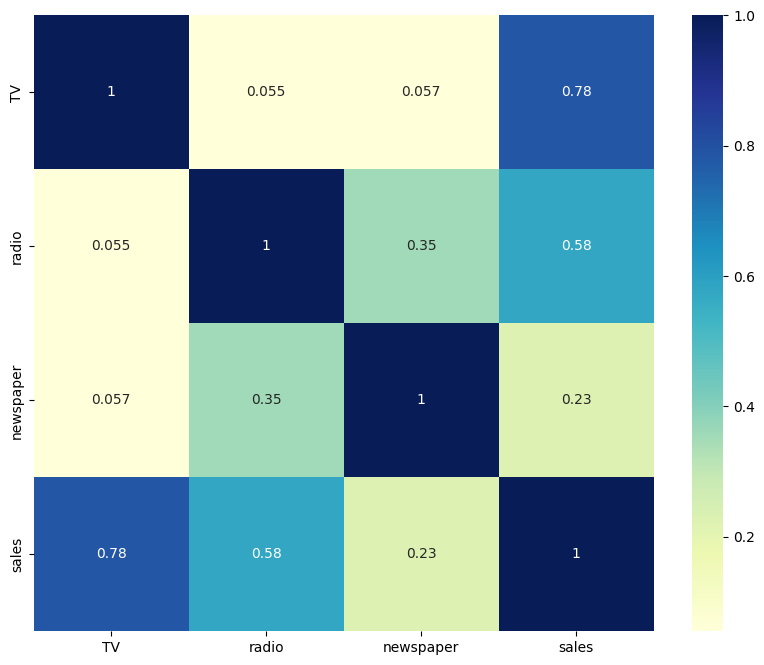

In [55]:
plt.figure(figsize=(10,8))
sns.heatmap(data.corr(numeric_only=True), cmap="YlGnBu", annot=True)

## Define predictors and target

In [56]:
X = data[['TV', 'radio', 'newspaper']]
# X = data[['TV', 'radio']]
y = data['sales']

Text(0.5, 1.0, 'newspaper vs Sales')

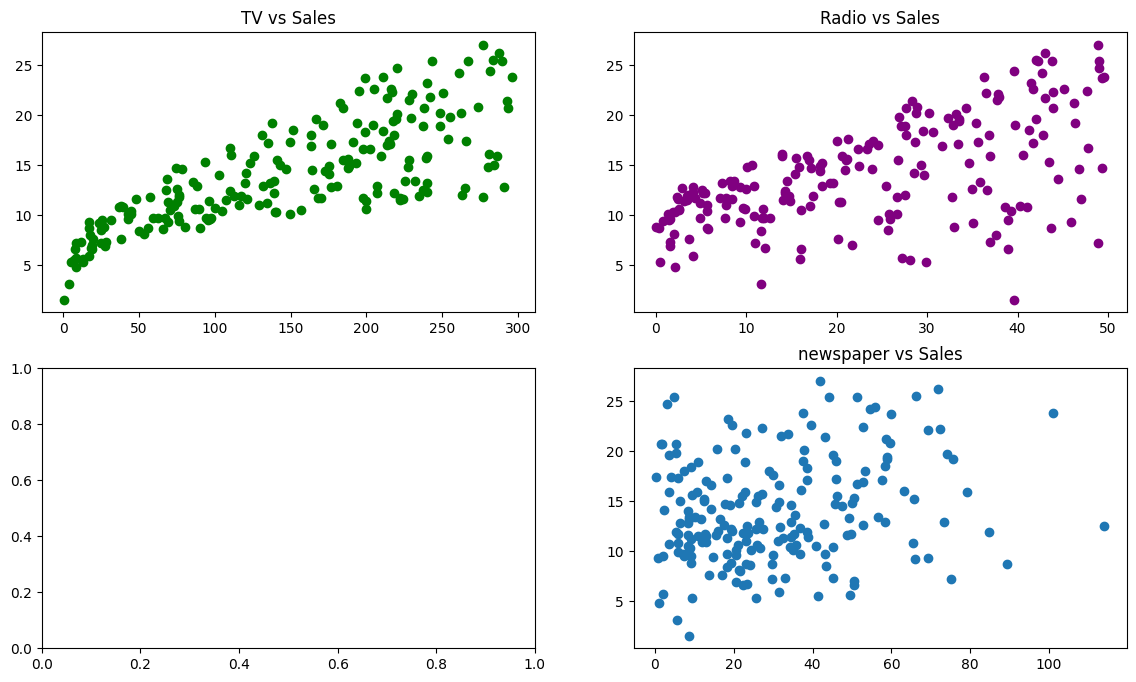

In [57]:
fig, axes = plt.subplots(2,2,figsize=(14,8))
axes[0,0].scatter(X.TV,y,color='g')
axes[0,0].set_title("TV vs Sales")
axes[0,1].scatter(X.radio,y,color='purple')
axes[0,1].set_title("Radio vs Sales")
# axes[1,0].scatter(X.const,y,color='r')
# axes[1,0].set_title("const vs Sales")
axes[1,1].scatter(X.newspaper,y)
axes[1,1].set_title("newspaper vs Sales")


## Statistical Modeling Using Statsmodels

In [58]:
# Adding Intercept Term (c)
X_const = sm.add_constant(X)

# Fitting the model
ols_model = sm.OLS(y, X_const).fit()
print(ols_model.summary())

# Making Predictions on Data
y_pred = ols_model.predict(X_const)

                            OLS Regression Results                            
Dep. Variable:                  sales   R-squared:                       0.897
Model:                            OLS   Adj. R-squared:                  0.896
Method:                 Least Squares   F-statistic:                     570.3
Date:                Thu, 08 May 2025   Prob (F-statistic):           1.58e-96
Time:                        11:35:36   Log-Likelihood:                -386.18
No. Observations:                 200   AIC:                             780.4
Df Residuals:                     196   BIC:                             793.6
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.9389      0.312      9.422      0.0

## 1. Residual Analysis

#### Calculating Residuals

In [59]:
residuals = y - y_pred

### Residual vs Fitted Graph

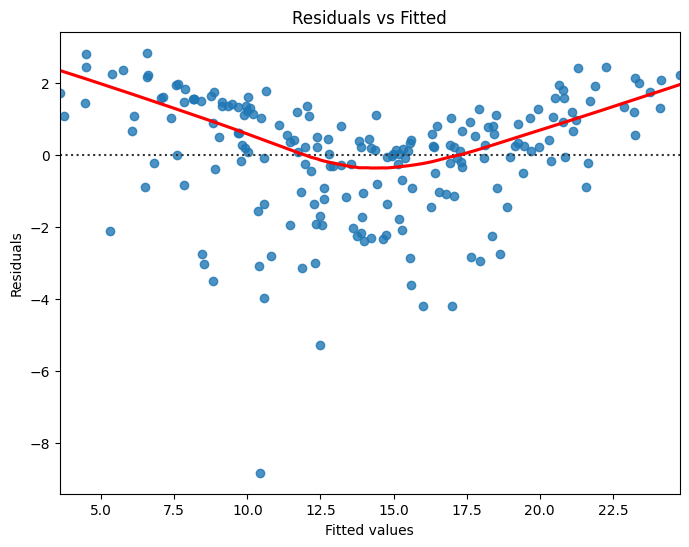

In [60]:
plt.figure(figsize=(8,6))
sns.residplot(x=y_pred, y=residuals, lowess=True, line_kws={'color': 'red'})
plt.xlabel('Fitted values')
plt.ylabel('Residuals')
plt.title('Residuals vs Fitted')
plt.show()

#### Q-Q Plot

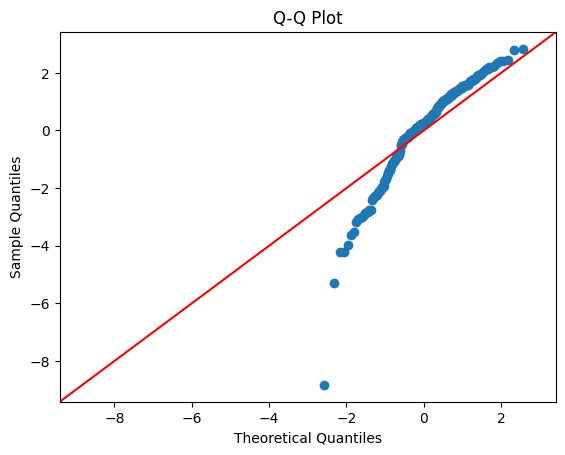

In [61]:
sm.qqplot(residuals, line='45')
plt.title('Q-Q Plot')
plt.show()

#### Histogram of residuals

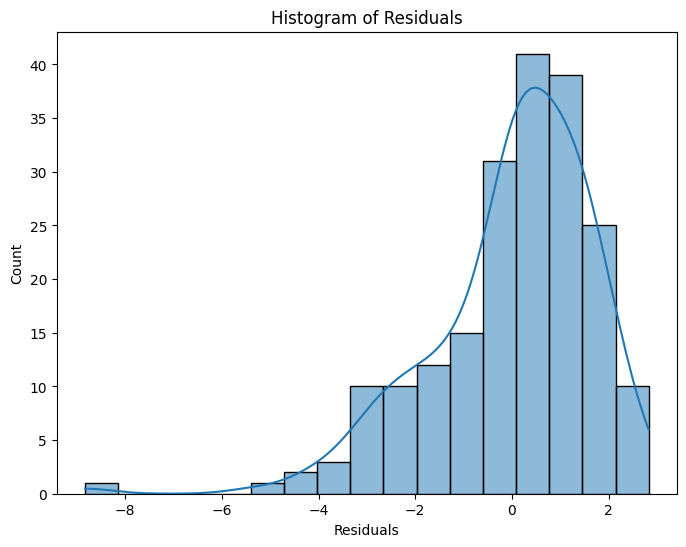

In [62]:
plt.figure(figsize=(8,6))
sns.histplot(residuals, kde=True)
plt.title('Histogram of Residuals')
plt.xlabel('Residuals')
plt.show()

## 2. Multicollinearity Check

In [63]:
vif_data = pd.DataFrame()
vif_data['feature'] = X.columns
vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(vif_data,"\n\nValues are in the range 0-5 so it's all right")


     feature       VIF
0         TV  2.486772
1      radio  3.285462
2  newspaper  3.055245 

Values are in the range 0-5 so it's all right


## 3. Influential Observations

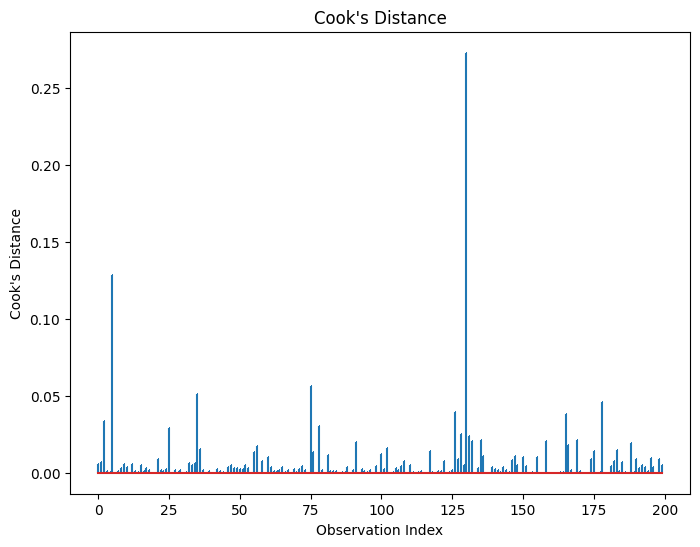

In [64]:
influence = ols_model.get_influence()
(c, p) = influence.cooks_distance
plt.figure(figsize=(8,6))
plt.stem(np.arange(len(c)), c, markerfmt=",")
plt.title("Cook's Distance")
plt.xlabel("Observation Index")
plt.ylabel("Cook's Distance")
plt.show()

## 4. Homoscedasticity Check

In [65]:
# Breusch-Pagan test
bp_test = het_breuschpagan(residuals, X_const)
labels = ['Lagrange multiplier statistic', 'p-value', 'f-value', 'f p-value']
print(dict(zip(labels, bp_test)))
print("\nP Value should be Greater than 0.05 for Homoscedasticity")

{'Lagrange multiplier statistic': 5.132872353285567, 'p-value': 0.16232215845412676, 'f-value': 1.7209042102915795, 'f p-value': 0.16399908905607216}

P Value should be Greater than 0.05 for Homoscedasticity


## 5. Normality Check

In [66]:
shapiro_test = stats.shapiro(residuals)
print('Shapiro-Wilk Test statistic:', shapiro_test[0], 'p-value:', shapiro_test[1])

Shapiro-Wilk Test statistic: 0.9176652036187539 p-value: 3.938571556266683e-09


## 6. Autocorrelation Check

In [67]:
dw_stat = durbin_watson(residuals)
print('Durbin-Watson statistic:', dw_stat)

Durbin-Watson statistic: 2.083648405294407


## 7. Goodness of Fit

In [68]:
print('R^2:', r2_score(y, y_pred))
print('Adjusted R^2:', 1 - (1 - r2_score(y, y_pred)) * (len(y) - 1) / (len(y) - X.shape[1] - 1))
print('RMSE:', np.sqrt(mean_squared_error(y, y_pred)))


R^2: 0.8972106381789522
Adjusted R^2: 0.8956373316204668
RMSE: 1.6685701407225697


## Summary

In [69]:
print("\n--- Summary of Diagnostics ---")
print(f"Residuals are {'normally distributed' if shapiro_test[1]>0.05 else 'not normally distributed'}.")
print(f"Homoscedasticity {'present' if bp_test[1]>0.05 else 'violated'} (Breusch-Pagan p-value: {bp_test[1]:.4f}).")
print(f"Durbin-Watson statistic close to 2: {dw_stat:.4f} (No autocorrelation if close to 2).")
print(f"VIF values (should be < 5 ideally):\n{vif_data}")


--- Summary of Diagnostics ---
Residuals are not normally distributed.
Homoscedasticity present (Breusch-Pagan p-value: 0.1623).
Durbin-Watson statistic close to 2: 2.0836 (No autocorrelation if close to 2).
VIF values (should be < 5 ideally):
     feature       VIF
0         TV  2.486772
1      radio  3.285462
2  newspaper  3.055245


# Polynomial Regression Examples

In [25]:
data = pd.DataFrame({
    'X':[0,20,40,60,80,100],
    'y':[0.002,0.0012,0.0060,0.0300,0.0900,0.2700]
})
data

,X,y
0,0,0.0020
1,20,0.0012
2,40,0.0060
3,60,0.0300
4,80,0.0900
5,100,0.2700


In [33]:
X = data["X"].values.reshape(-1, 1)
y = data["y"].values.reshape(-1, 1)

### Fitting a simple linear regression model

In [34]:
# Fitting Linear Regression to the dataset
from sklearn.linear_model import LinearRegression
lin = LinearRegression()
lin.fit(X, y)

LinearRegression()

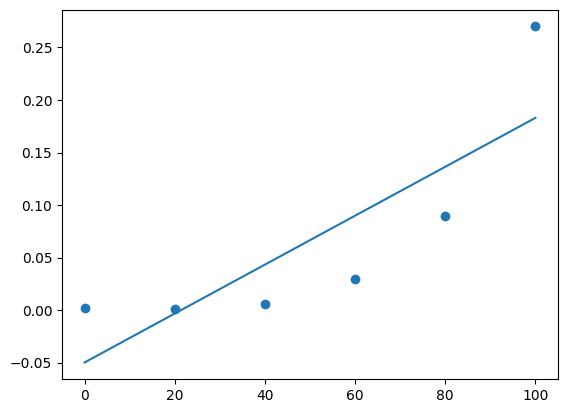

In [35]:
plt.scatter(X,y)
plt.plot(X,lin.predict(X))

### Simple LinearRegression could not fit the data well. Let's try Polynomial Regression.

In [45]:
from sklearn.preprocessing import PolynomialFeatures

poly_t = PolynomialFeatures(degree=5)
X_t = poly_t.fit_transform(X)
poly_t.fit(X_t, y)
lin2 = LinearRegression()
lin2.fit(X_t, y)

LinearRegression()

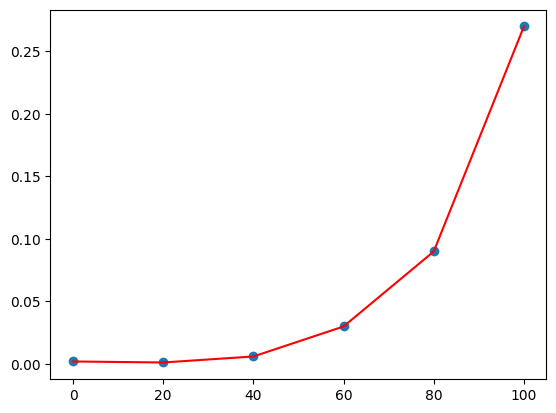

In [46]:
plt.scatter(X,y)
plt.plot(X,lin2.predict(X_t),color='red')